In [4]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

# Load the CSV file into a pandas DataFrame.
df = pd.read_csv('IMDB Dataset.csv')

In [2]:
# Initial exploration
print(df.head())
print(df.info())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [3]:
# 2 columns: review and sentiment
# both non null
# total 50000
# checking sentiment distribution
print(df['sentiment'].value_counts())

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [6]:
# preprocessing
# removal of html tags, stopwords, puncuations etc
# lowercase, tokenization, stemming/lemmatization

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text) #removal of html tags
    text = text.lower() #lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text) #removal of punctuations
    
    tokens = text.split() # tokenization
    
    stop_words = set(stopwords.words('english')) #english stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words] #remove stopwords
    
    cleaned_text = ' '.join(filtered_tokens) #final clean text
    return cleaned_text


df['cleaned_review'] = df['review'].apply(preprocess_text)
print("Preprocessing complete.")

# Compare before and after preprocessing
print("\nOriginal Review:\n", df['review'][0])
print("\nCleaned Review:\n", df['cleaned_review'][0])

Preprocessing complete.

Original Review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say th

In [7]:
# Building the baseline model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# First, we need a numerical target variable. Let's map 'positive' to 1 and 'negative' to 0.
df['sentiment_numeric'] = df['sentiment'].map({'positive': 1, 'negative': 0})

X = df['cleaned_review']
y = df['sentiment_numeric']

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # max_features=5000 means we'll only consider the top 5000 most frequent words

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of TF-IDF matrix for training data:", X_train_tfidf.shape)

# Logistic Regression Model
model = LogisticRegression()

# Training the model on the TF-IDF vectors of the training data
model.fit(X_train_tfidf, y_train)
print("Model training complete.")


#Evaluation
# Making predictions on the unseen test data
y_pred = model.predict(X_test_tfidf)

# Calculating the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Training data shape: (40000,)
Testing data shape: (10000,)
Shape of TF-IDF matrix for training data: (40000, 5000)
Model training complete.
Accuracy: 0.8914

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4961
    Positive       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [8]:
# 0.8914 accuracy for baseline model is excellent
# Lets see if our so-called 'superior model' beats this

# Advanced model using RNN/LSTM

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# --- Model Constants ---
VOCAB_SIZE = 10000        # Max number of words to keep in the vocabulary
MAX_SEQUENCE_LENGTH = 250 # Max length of a review (in words)
EMBEDDING_DIM = 128       # Dimension of the word embeddings

# Tokenizing the text for DL
# We use Keras's Tokenizer, which is different from simple splitting.
# It builds a vocabulary and converts our words into integer indices.
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>') # <OOV> is for out-of-vocabulary words

tokenizer.fit_on_texts(X_train)

# Converting the text to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# padding to ensure max_length maintained
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Shape of padded training data:", X_train_padded.shape)
print("Shape of padded testing data:", X_test_padded.shape)

# build model
model_lstm = Sequential([
    # Layer 1: Embedding Layer
    # Turns positive integers (indexes) into dense vectors of fixed size.
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),

    # Layer 2: LSTM Layer
    # The core of our model for processing sequences. Dropout helps prevent overfitting.
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    # Layer 3: Output Layer
    # A single neuron with a sigmoid activation function for binary classification.
    Dense(1, activation='sigmoid')
])

# We configure the model for training.
model_lstm.compile(
    loss='binary_crossentropy',       # Best for binary (0/1) classification
    optimizer='adam',                 # A popular and effective optimizer
    metrics=['accuracy']              # We want to track accuracy
)

print("--- LSTM Model Summary ---")
model_lstm.summary()

# training
print("\nTraining the LSTM model... This will take a few minutes.")
history = model_lstm.fit(
    X_train_padded, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    verbose=1
)
print("LSTM model training complete.")

# Evaluation
loss, accuracy = model_lstm.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Shape of padded training data: (40000, 250)
Shape of padded testing data: (10000, 250)
--- LSTM Model Summary ---


c:\Users\HP\anaconda3\envs\ai_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model... This will take a few minutes.
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 373s 592ms/step - accuracy: 0.5045 - loss: 0.6936 - val_accuracy: 0.5080 - val_loss: 0.6917
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 277s 424ms/step - accuracy: 0.5243 - loss: 0.6836 - val_accuracy: 0.5226 - val_loss: 0.6790
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1190s 2s/step - accuracy: 0.5413 - loss: 0.6578 - val_accuracy: 0.5087 - val_loss: 0.7026
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 467ms/step - accuracy: 0.5676 - loss: 0.6454 - val_accuracy: 0.7869 - val_loss: 0.5194
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 253s 405ms/step - accuracy: 0.8296 - loss: 0.4167 - val_accuracy: 0.8662 - val_loss: 0.3332
LSTM model training complete.
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.8657 - loss: 0.3377
Test Accuracy: 0.8662
Test Loss: 0.3332


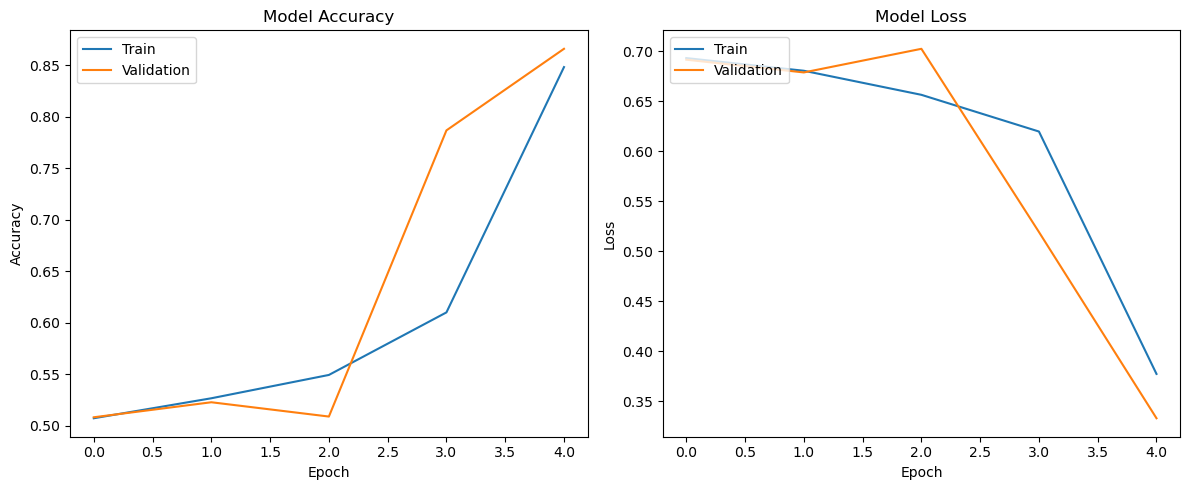

In [9]:
# wooh...0.8662 on the advanced model
# lets plot first

import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function with the history object from our LSTM training
plot_history(history)

Retraining the LSTM model with Early Stopping...
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 427ms/step - accuracy: 0.9048 - loss: 0.2663 - val_accuracy: 0.8777 - val_loss: 0.3084
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 370ms/step - accuracy: 0.9293 - loss: 0.2084 - val_accuracy: 0.8833 - val_loss: 0.3123
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 382ms/step - accuracy: 0.9477 - loss: 0.1666 - val_accuracy: 0.8809 - val_loss: 0.3359
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8772 - loss: 0.3124
Final Test Accuracy: 0.8777
Final Test Loss: 0.3084

Plotting final learning curves:


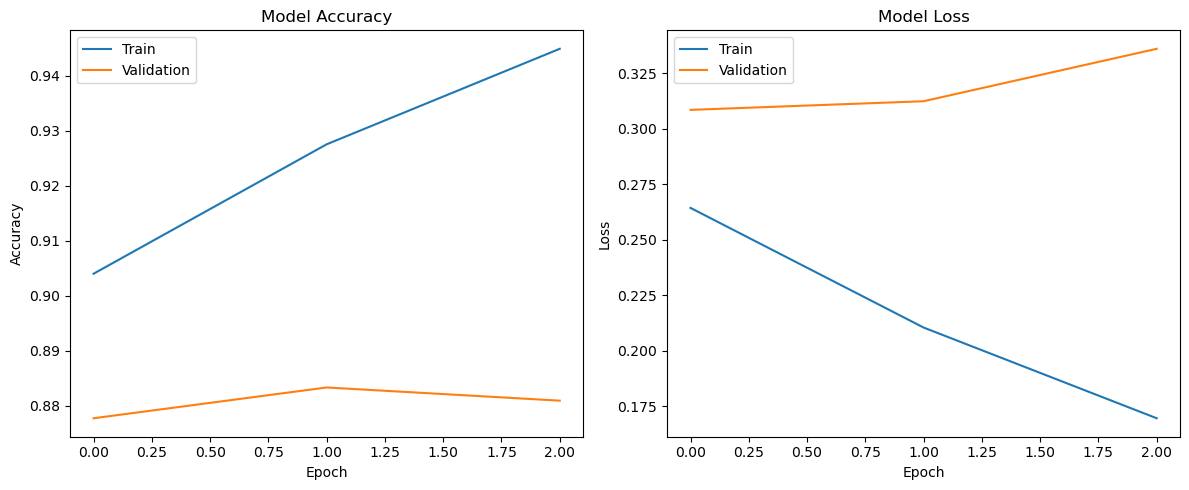

In [10]:
# plots show no overfitting, hence it is undertrained
# so lets solve this and help the advanced model reach its max potential
# we will train it for more epochs and use early stopping to stop it at its highest potential aka the sweet spot


from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2, # stop training if val_loss doesn't improve for 2 consecutive epochs
    restore_best_weights=True, # update weights
    verbose=1
)

# Retraining
print("Retraining the LSTM model with Early Stopping...")
history_final = model_lstm.fit(
    X_train_padded, y_train,
    epochs=15,  # We can set a higher number of epochs now
    batch_size=64,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping], # Add the callback here
    verbose=1
)

# Evaluation
loss, accuracy = model_lstm.evaluate(X_test_padded, y_test)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test Loss: {loss:.4f}")

# Plot
print("\nPlotting final learning curves:")
plot_history(history_final)

In [11]:
# we can clearly see its overfitting here.
# even peak performance of the advanced model is worse than that of the baseline model.
# hence TF-IDF works best here.